"""
An example to demonstrate online linear system identification

We demonstrate the use of OnlineLinearModel class with a simple linear system.
Take a 2D time-varying system dx/dt=A(t)x(t)+B(t)u(t), where A(t) and B(t)
are slowly varying with time. In particular, we take A(t)=(1+eps\*t)\*A,
B(t)=(1+eps\*t)\*B, and eps = 0.1 is small. It is discretize with
time step dt = 0.1. Denote the discrete system as x(k+1)=A(k)x(k)+
B(k)u(k).

At time step t+1, we need to include new snapshot pair x(t), u(t), x(t+1).
We would like to update the adaptive model in real-time

Authors: 
Hao Zhang

References:
Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta.
"Online dynamic mode decomposition for time-varying systems."
SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.

Created:
June 2017.
"""

In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip list

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from osysid import OnlineLinearModel
from control import lqr, StateSpace, ctrb

In [3]:
# define dynamics, negative damping -> unstable
# https://en.wikipedia.org/wiki/Harmonic_oscillator#Damped_harmonic_oscillator
n = 2
k = 1
A = np.array([[0, 1], [-1, 0.2]])
B = np.array([[0], [1]])
C = np.eye(n)
D = np.zeros((n, k))

# check poles
sys = StateSpace(A, B, np.eye(n), np.zeros((n, k)))
print(f"open loop poles: {sys.pole()}")

# check controllability
Ctrb = ctrb(A, B)
assert np.linalg.matrix_rank(Ctrb) == n

# slowly time-varying dynamics
def dyn(t, x, u, epsilon = 1e-3):
    At = (1 + epsilon * t) * A
    Bt = (1 + epsilon * t) * B
    dxdt = At.dot(x) + Bt.dot(u)
    return dxdt

open loop poles: [0.1+0.99498744j 0.1-0.99498744j]


In [5]:
# set up simulation parameter
dt = 0.02
tmax, tc = 20, 0.5
T, kc = int(tmax / dt), int(tc / dt)
tspan = np.linspace(0, tmax, T + 1)

# online linear system identification setup
alpha = 0.01 ** (2.0 / kc)
olm = OnlineLinearModel(n, k, None, alpha)

# store data mtrices
x = np.zeros([n, T])
u = np.zeros([k, T])

# initial condition, state and control
x0 = np.array([1, 0])
u0 = 0

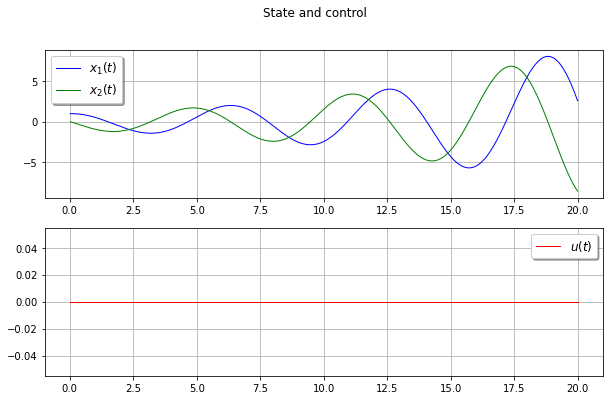

In [6]:
# uncontrolled system
# initial condition
x[:, 0] = x0
u[:, 0] = u0
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(t * dt, x[:, t - 1], u[:, t - 1])
    u[:, t] = 0

def plot_state_control(x, u):
  fig, axs = plt.subplots(2, figsize=(10, 6))
  fig.suptitle('State and control')
  axs[0].plot(tspan[1:], x[0, :], "b-", linewidth=1.0, label="$x_1(t)$")
  axs[0].plot(tspan[1:], x[1, :], "g-", linewidth=1.0, label="$x_2(t)$")
  axs[0].legend(loc="best", fontsize=12, shadow=True)
  axs[0].grid()

  axs[1].plot(tspan[1:], u.reshape(-1), "r-", linewidth=1.0, label="$u(t)$")
  axs[1].legend(loc="best", fontsize=12, shadow=True)
  axs[1].grid()

plot_state_control(x, u)

In [ ]:
# initial condition, state and control
x[:, 0] = x0
u[:, 0] = u0

# control system simulation
for t in range(1, T):
    # forward the system for one step
    x[:, t] = x[:, t - 1] + dt * dyn(t * dt, x[:, t - 1], u[:, t - 1])
    # use new measurement to update online system identification
    olm.update(x[:, t - 1], u[:, t - 1], x[:, t])
    # apply control if we have collected enough data
    if t > 2 * max(n, n + k):
        # convert to continuous representation
        Ac = (olm.A - np.eye(n)) / dt
        Bc = olm.B / dt
        # get LQR gain, output = state
        sys = StateSpace(Ac, Bc, C, D, dt=0)
        K, S, E = lqr(sys, np.eye(n), np.eye(k))
        # apply control
        u[:, t] = -1.0 * K.dot(x[:, t])
        # clip control
        u[:, t] = np.clip(u[:, t], -10, 10)
        # show progress
        if t % 100 == 0:
          print(f"x(t)={x[:, t]}")
          print(f"u(t)={u[:, t]}")
          print(f"Ac={Ac}")
          print(f"Bc={Bc}")
          print(f"K={K}")
    # random small perturbation if not enough data yet
    else:
        u[:, t] = 1e-1 * np.random.randn()

plot_state_control(x, u)